## Import Libraries

In [101]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [45]:
df = pd.read_csv(r"C:\Users\Yasserkm\Downloads\data_saudi_used_cars.csv")

In [46]:
df.shape

(5624, 11)

In [47]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [48]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [49]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [50]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [51]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [52]:
# for i in categorical_features:
#     print (df[i].value_counts())

In [53]:
df = df[df['Year']>=2000]

In [54]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [55]:
df.shape

(5364, 11)

In [56]:
# # Calculate the frequency of each 'Make'
# make_counts = df['Make'].value_counts()

# # Filter 'Type' values that appear 10 or more times
# df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [57]:
df.shape

(5364, 11)

In [58]:
#df[df['Type']=='Other']

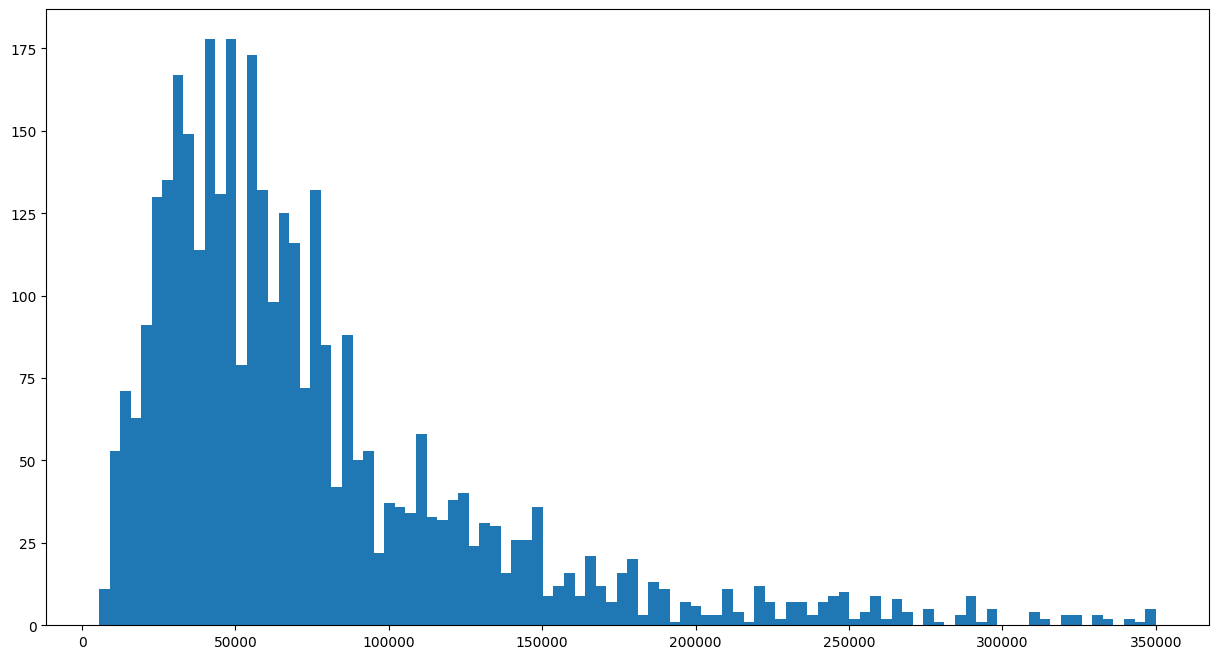

In [59]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [60]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [61]:
df.shape

(3566, 11)

In [62]:
#df[df['Mileage']<1000]

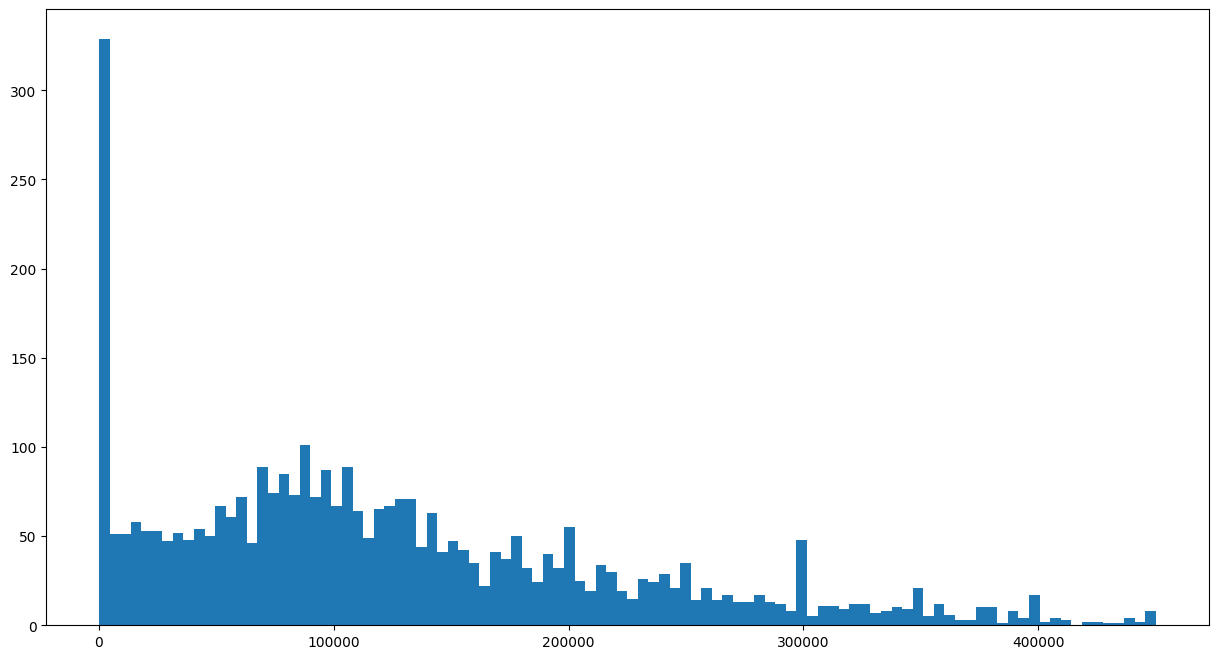

In [63]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [64]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [65]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [66]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [67]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [68]:
df.shape

(3511, 325)

In [69]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
2,2015,5.0,140000,False,260000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False


#### 3. Feature selection

In [70]:
# sns.heatmap(df.corr(), annot=True);

In [71]:
correlation = df.corr()
print(correlation['Price'].sort_values(ascending=False))

Price               1.000000
Year                0.383150
Options_Full        0.335431
Engine_Size         0.327441
Make_Mercedes       0.298269
                      ...   
Origin_Saudi       -0.181963
Make_Hyundai       -0.206750
Options_Standard   -0.278682
Mileage            -0.301282
Negotiable               NaN
Name: Price, Length: 325, dtype: float64


In [72]:
# Set the correlation threshold
threshold = 0.25  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['Price']) > threshold]['Price'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Make_Mercedes', 'Options_Full', 'Options_Standard'],
      dtype='object')

In [73]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Price', 'Type_Land Cruiser',
       'Make_Mercedes', 'Options_Full', 'Options_Standard']

In [74]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Price,Type_Land Cruiser,Make_Mercedes,Options_Full,Options_Standard
1,2014,8.0,80000,120000,False,False,True,False
2,2015,5.0,140000,260000,False,False,True,False
3,2015,2.4,220000,42000,False,False,False,False
5,2019,2.0,25000,58000,False,False,False,False
6,2012,4.8,189000,85000,False,False,True,False


#### 4. Prepare train and test data

In [75]:
# Prepare data
X = df.drop(['Price'], axis=1)
y = df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
X.shape

(3511, 7)

## Buliding the Model

In [77]:
model = LinearRegression()

In [78]:
ridge_model = Ridge()  # You can adjust alpha to see different resu

In [79]:
lasso_model = Lasso()  # You can adjust alpha to see different results

In [89]:
param_grid = {
    'alpha': [0, 0.0000003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  # Regularization strength
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [90]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [91]:
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [92]:
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [104]:
grid_search_ridge.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [105]:
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [106]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

In [107]:
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [108]:
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [109]:
# Best hyperparameter
print("Best parameters found: ", grid_search_ridge.best_params_)

# Best model
best_ridge = grid_search_ridge.best_estimator_

Best parameters found:  {'alpha': 5}


In [110]:
# Best hyperparameter
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_lasso = grid_search_lasso.best_estimator_

Best parameters found:  {'alpha': 5}


In [114]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)

In [115]:
y_pred_lasso_cv = best_lasso.predict(X_test_scaled)

## Interpretation of the Model

In [116]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,27423.548167
Engine_Size,22536.091491
Mileage,-6637.422709
Type_Land Cruiser,12346.705166
Make_Mercedes,15546.063688
Options_Full,9057.162938
Options_Standard,-4692.316630


In [118]:
print(model.intercept_) 

75439.30021367459


In [119]:
coeff_df = pd.DataFrame(lasso_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,27422.379088
Engine_Size,22534.952473
Mileage,-6636.845901
Type_Land Cruiser,12345.870558
Make_Mercedes,15545.129518
Options_Full,9056.869984
Options_Standard,-4691.844700


In [120]:
coeff_df = pd.DataFrame(best_lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,27417.686081
Engine_Size,22530.407445
Mileage,-6634.554539
Type_Land Cruiser,12342.552434
Make_Mercedes,15541.410693
Options_Full,9055.643231
Options_Standard,-4689.979277


In [121]:
coeff_df = pd.DataFrame(ridge_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,27408.461033
Engine_Size,22524.413127
Mileage,-6641.031376
Type_Land Cruiser,12343.583397
Make_Mercedes,15539.805982
Options_Full,9055.389797
Options_Standard,-4694.146734


In [122]:
coeff_df = pd.DataFrame(best_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
Year,27348.307393
Engine_Size,22477.832295
Mileage,-6655.360267
Type_Land Cruiser,12331.104892
Make_Mercedes,15514.834824
Options_Full,9048.317177
Options_Standard,-4701.420570


## Evaluating the Model 

1. Mean Square Error

In [123]:
y_base = [y_train.mean()] * len(y_test)

In [124]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 3525053139.6218147


In [125]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 1375767768.9121442
Mean Squared Error for testing: 1414582862.7354758


2. Mean Absolute Error

In [126]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 42200.97317509818


In [127]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 25122.176211672126
Mean Absolute Error for testing: 25659.531201197213


3. Root Mean Squared Error

In [128]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 205.42875449921362


In [129]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 37091.343584617476
Root Mean Squared Error for testing: 37610.94073185987


4. R Square

In [130]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.570633927895497
R Square for testing: 0.5982086325574314


#### Predictions vs. Real Values

In [131]:
predictions = model.predict(X_test_scaled)
#predictions

In [132]:
Real_Values = np.array(y_test)
#Real_Values

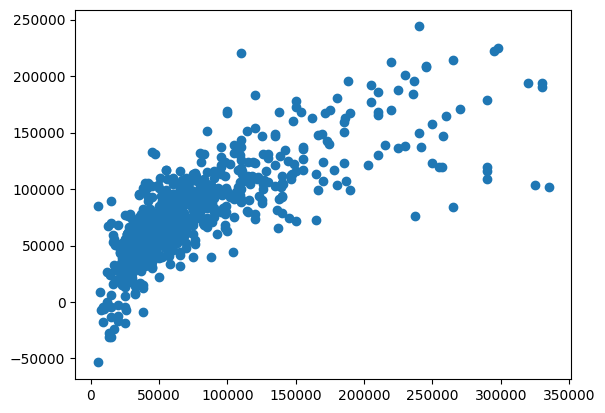

In [133]:
plt.scatter(Real_Values,predictions); 

#### Residual Histogram

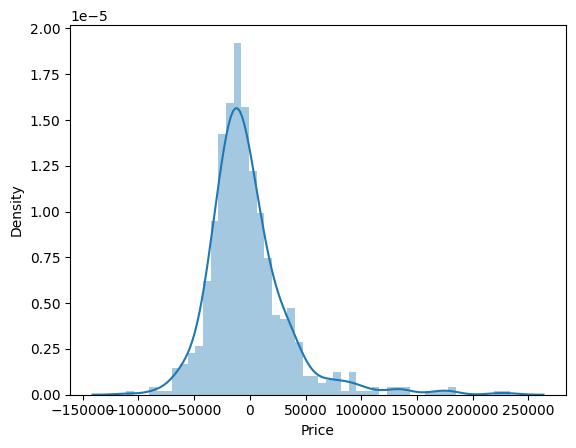

In [134]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution